# Tema 4: model de regresie logistica multinomiala antrenat cu Pytorch

Implementati un model de regresie logistica multinomiala pentru clasificarea celor 10 tipuri de cifre din setul MNIST.

Modificarile pe care trebuie sa le aveti in vedere (fata de regresia logistica binara) sunt:
1. in definirea lui Dataset nu se mai face filtrare dupa clasele pozitive si negative; se lasa toate datele
1. In definirea clasei modelului, stratul `self.fully_connected` trebuie sa fie cu numarul de iesiri egal cu numarul de clase
1. La predictie, pentru fiecare vector de intrare (cifra reprezentata ca vector de 784 de valori) modelul produce un vector de 10 probabilitati. Clasa se decide ca indicele pe care probabilitatea este maxima. Aceasta afecteaza implementarea functiei de testare
1. Se reccomanda ca in functia `forward` a modelului sa nu se mai aplice si functia softmax, ci sa se returneze direct logitii (valoarea producsa de aplicarea stratului liniar, adica inmultirea dintre matricea de ponderi si intrare)
1. Functia de eroare `loss_fn` este `torch.nn.CrossEntropyLoss`. Aceasta preia logitii produsi de model (punctul de mai sus)

Creati o matrice de confuzie pentru clase; puteti folosi [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

Predarea acestei aplicatii se pana in 22 decembrie ora 24, in cadrul temei 4 de pe platforma. Modul de predare si de rpezentare aeste la fel ca pentru temele precedente.

In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
from typing import List
import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.5.1+cpu  Device: cpu


## Dataset

In [2]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import os
from typing import Tuple

In [3]:
class MNISTDataset(Dataset):
    
    def __init__(self, path_csv: str):
        """
        Initializes dataset, using csv at given path.
        :param path_csv: path to the csv file containing train/test dataset
        """
        super(MNISTDataset, self).__init__()
        assert os.path.exists(path_csv) and os.path.isfile(path_csv), f'Calea {path_csv} nu indica spre un fisier'
        self.path_csv : str = path_csv
        
        _all_digits : np.ndarray = pd.read_csv(path_csv, header=None).values
        # input values - x, labels - y 
        self.y = _all_digits[:, 0]
        self.x = _all_digits[:, 1:]
        # values 0-255 from input set x are scaled to 0-1
        self.x = self.x / 255

        # convert numpy -> torch.Tensor
        self.x = torch.Tensor(self.x)
        self.y = torch.Tensor(self.y).long()
        self.y = torch.nn.functional.one_hot(self.y, num_classes=10).to(torch.float)
        
    def __len__(self) -> int:
        """
        Returns the length of the current dataset (num of elements)
        :return: the length of the current dataset
        """
        return len(self.y)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns tuple of (input tensor, expected output) on position :param index:
        :param index: position to retreive the item from
        :return: tuple of (input tensor - of 784 elements, class: 0-9)
        """
        return self.x[index, :], self.y[index]

In [4]:
train_ds = MNISTDataset('./data/mnist_train.csv') # check path!
test_ds = MNISTDataset('./data/mnist_test.csv') # check path!

In [5]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

## Model

In [6]:
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_size : int = 784, num_classes : int = 10):
        """
        Initializes MultinomialLogisticRegression.
        :input_size: input vector size, for MNIST = 784
        :nmb_classes: number of possible outputs; for MNIST -> 10 digits -> 10 classes
        """
        super(MultinomialLogisticRegression, self).__init__()
        # initialize "theta" (as a matrix of input_size x nmb_classes)
        self.fully_connected = nn.Linear(input_size, num_classes)

    def forward(self, x):
        """
        Given an input batch, returns predictions for x (y_hat) 
        :param x: Batch of input tensors (shape - (batch_size, input_size))
        :returns: predicted output for input batch  (of shape (batch_size, nmb_classes))
        """
        # calculates theta.T * x (extended)
        output = self.fully_connected(x)
        return output

In [7]:
def evaluate(model: nn.Module, loader: DataLoader, device: torch.device, loss_fn = torch.nn.CrossEntropyLoss()) -> Tuple[float, float]:
        """
        Evaluates the model against :param loader:
        
        :param loader: DataLoader to be evaluated on
        :param device: Device used
        :returns: Tuple[accuracy the model has given on the dataloader, the loss] 
        """
        total_inputs: int = 0
        correctly_classified: torch.Tensor = 0
        all_loss: float = 0
        # switch model to eval mode
        model.eval()
        with torch.no_grad():
            for input, expected_output in loader:
                input, expected_output = input.to(device), expected_output.to(device)

                # extract predictions for current minibatch;
                y_hat: torch.Tensor = model(input)
                # extract best scoring class for each input value in minibatch
                predicted_class: torch.Tensor = torch.argmax(y_hat, dim=1)
                # count correctly classified values
                correctly_classified += (predicted_class == torch.argmax(expected_output, dim=1)).sum().item()
                total_inputs += expected_output.size(0)

                # calculate loss for current minibatch
                loss = loss_fn(y_hat, expected_output)
                all_loss += loss.item() * expected_output.size(0)
        accuracy  = 100 * correctly_classified / total_inputs
        all_loss = all_loss / total_inputs
        # switch model back to train mode
        model.train()
        return accuracy, all_loss # accuracy, loss


In [8]:
model = MultinomialLogisticRegression()
model.to(device)
summary(model, input_size=(10, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [9]:
accuracy, loss = evaluate(model, test_loader, device)
print(f'Initial accuracy: {accuracy}%')
print(f'Initial loss: {loss}')

Initial accuracy: 11.54%
Initial loss: 2.2848898040771486


## Training

In [10]:
optimizer = torch.optim.SGD(params=model.parameters()) # Use torch SGD oprimizer
loss_fn = torch.nn.CrossEntropyLoss()
epochs: int = 30

In [11]:
train_losses: List[float] = []
accuracies: List[float] = []

acc_test, loss_test = evaluate(model, test_loader, device, loss_fn)
accuracies.append(acc_test)
print(f'Epoca: 0/{epochs}: acuratete pe setul de testare = {acc_test:.4f}%\n')

model.train()
for epoch in range(epochs):
    epoch_loss: float = 0
    total_items: int = 0

    for x, y in train_loader:
        # extract input and expected output from current minibatch;
        # swithed y type from Float to Long in order to apply CrossEntropyLoss fn
        x, y = x.to(device), y.to(device)

        # reset gradients to 0
        optimizer.zero_grad()
        y_hat = model(x)
        # calculate loss function for current minibatch
        loss: float = loss_fn(y_hat, y)
        # the loss will be the mean of the loss values over the curent minibatch
        # => loss * len(minibatch) for calculating the cumulated value of loss/minibatch
        epoch_loss += loss.item() * x.size(0)
        total_items += x.size(0)

        # calculate gradients
        loss.backward()
        
        # apply gradients
        optimizer.step()
    
    train_losses.append(epoch_loss / total_items)
    print(f'Epoca: {epoch+1}/{epochs}: loss = {epoch_loss:.7f}')
    acc_test, loss_test = evaluate(model, test_loader, device, loss_fn)
    accuracies.append(acc_test)
    print(f'Epoca: {epoch + 1}/{epochs}: acuratete pe setul de testare = {acc_test:.4f}%\n')

Epoca: 0/30: acuratete pe setul de testare = 11.5400%

Epoca: 1/30: loss = 98117.6501198
Epoca: 1/30: acuratete pe setul de testare = 80.0200%

Epoca: 2/30: loss = 62363.1323299
Epoca: 2/30: acuratete pe setul de testare = 83.5100%

Epoca: 3/30: loss = 49568.1746149
Epoca: 3/30: acuratete pe setul de testare = 85.0600%

Epoca: 4/30: loss = 43060.7482557
Epoca: 4/30: acuratete pe setul de testare = 86.1300%

Epoca: 5/30: loss = 39057.3173103
Epoca: 5/30: acuratete pe setul de testare = 86.9900%

Epoca: 6/30: loss = 36310.9347420
Epoca: 6/30: acuratete pe setul de testare = 87.3600%

Epoca: 7/30: loss = 34290.2615490
Epoca: 7/30: acuratete pe setul de testare = 87.7600%

Epoca: 8/30: loss = 32727.2100067
Epoca: 8/30: acuratete pe setul de testare = 87.9500%

Epoca: 9/30: loss = 31477.4190836
Epoca: 9/30: acuratete pe setul de testare = 88.1800%

Epoca: 10/30: loss = 30449.0244579
Epoca: 10/30: acuratete pe setul de testare = 88.3200%

Epoca: 11/30: loss = 29584.3987765
Epoca: 11/30: acur

Creati graficele pentru valorile functiei de cost si acuratetea pe parcursul antrenarii:

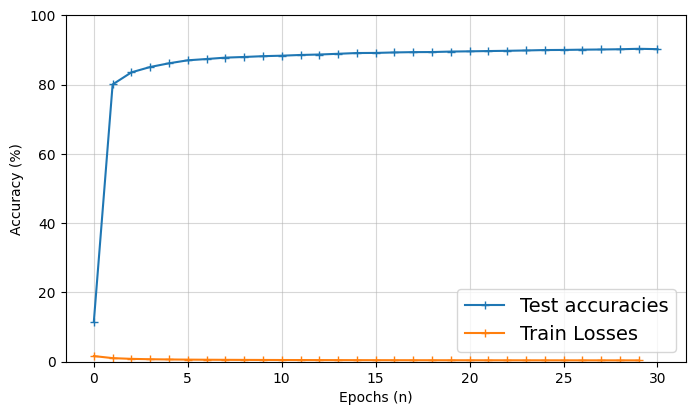

In [12]:
 # cod...
plt.figure(figsize=(8, 4.5))
plt.plot(range(len(accuracies)), accuracies, marker='+', label="Test accuracies")
plt.plot(range(len(train_losses)), train_losses, marker='+', label="Train Losses")
plt.xlabel('Epochs (n)')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.legend(prop={"size" : 14})
plt.grid(True, alpha=0.5)
plt.show()

## Confusion Matrix

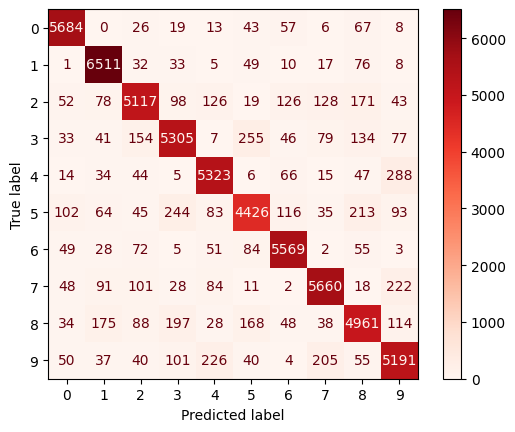

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_classes: torch.Tensor = []
prediction_classes: torch.Tensor = []

model.eval()
with torch.inference_mode():
    for x_true, y_true in train_loader:
        y_pred = model(x_true)
        true_classes.extend(torch.argmax(y_true, axis=1))
        prediction_classes.extend(torch.argmax(y_pred, axis=1)) # clasele prezise

conf_matrix = confusion_matrix(true_classes, prediction_classes)
confDisplay = ConfusionMatrixDisplay(conf_matrix)
confDisplay.plot(cmap=plt.cm.Reds)
plt.show()